# Walmart Sales: Exploratory Data Analysis  

In this notebook I carried out a basic exploratory data analysis (EDA) on the Wallmart sales data [Kaggle competition](https://www.kaggle.com/competitions/walmart-sales-forecasting/overview) to:  
- Identify the number of samples and variables
- Identify the kinds of variables available
- Define if data is to be cleaned/imputated based on missing values
- Explore data to reveal patterns which may explain output of model
- Identify if there are any strongly correlated variables
- Define the pre-processing to be done on categorical/numerical variables
- Define if the target variable needs any pre-processing

## Import libraries


In [1]:
import pandas as pd
import numpy as np

import datetime
import calendar

import seaborn as sns
import matplotlib.pyplot as plt

# Import my own functions
from src.data.data_processing import convert_date_fn
from src.visualization.visualize import palette_20

# Plotting config
sns.set_theme(style="white")

## Import data

In [2]:
# Import raw data
data_raw_df=pd.read_csv("data/raw/Walmart_Store_sales.csv")
print("There are {} samples and {} variables present in the data".format(data_raw_df.shape[0], data_raw_df.shape[1]))
data_raw_df.head()

There are 150 samples and 8 variables present in the data


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


## Data dictionary

In [3]:
data_raw_dic=pd.read_csv("references/Walmart_Store_sales_dictionary.txt")
data_raw_dic

,variable,description
0,Store,the store number
1,Date,the week
2,Weekly_Sales,sales for the given department in the given store
3,Holiday_Flag,whether the week is a special holiday week
4,Temperature,average temperature in the region (in Fahrenheit)
5,Fuel_Price,cost of fuel in the region
6,CPI,the consumer price index
7,Unemployment,the unemployment rate


## Basic data description

### Variable types

In [4]:
#Check the data type of each variable and get idea of number of non-null variables
data_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         150 non-null    float64
 1   Date          132 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  138 non-null    float64
 4   Temperature   132 non-null    float64
 5   Fuel_Price    136 non-null    float64
 6   CPI           138 non-null    float64
 7   Unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.5+ KB


### Data description: statistics

In [5]:
# Look at distribution of variable
data_raw_df.describe(include='all')

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000


### Missing values

In [6]:
# Number and percentage of missing values. Sort samples by highest percentage of missing values
dict_missing_vals = {"variable" : data_raw_df.columns.tolist(), "total_missing_vals":data_raw_df.isnull().sum().tolist(), "per_missing_vals": (100*data_raw_df.isnull().sum()/data_raw_df.shape[0]).tolist() }

pd.DataFrame(dict_missing_vals).sort_values(by=['per_missing_vals'], ascending=False)


,variable,total_missing_vals,per_missing_vals
1,Date,18,12.000000
4,Temperature,18,12.000000
7,Unemployment,15,10.000000
2,Weekly_Sales,14,9.333333
5,Fuel_Price,14,9.333333
3,Holiday_Flag,12,8.000000
6,CPI,12,8.000000
0,Store,0,0.000000


### Target variable distribution  
Visualize in more detail distribution of the target variable (Weekly Sales)

(150, 8)
(136, 8)
Quantile distribution of Weekly Sales
 0.00    2.689290e+05
0.25    6.050757e+05
0.50    1.261424e+06
0.75    1.806386e+06
1.00    2.771397e+06
Name: Weekly_Sales, dtype: float64


[Text(0.5, 1.0, 'Distribution of Weekly Sales')]

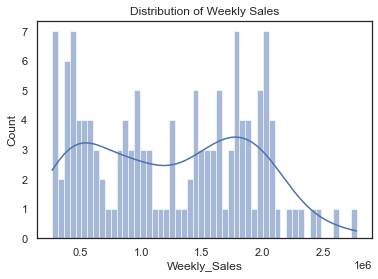

In [7]:
# Plot distribution of weekly sales

# Create copy of raw dataframe without null values
data_df = data_raw_df.copy()
data_df.dropna(subset=['Weekly_Sales'], inplace=True)

print(data_raw_df.shape)
print(data_df.shape)

# Print quantile for Weekly Sales
print('Quantile distribution of Weekly Sales\n', data_df['Weekly_Sales'].quantile([0,0.25,0.5,0.75,1]))

# Histogram of weekly sales distribution
fig = sns.histplot(data_df, x="Weekly_Sales", bins=52, kde=True)
fig.set(title='Distribution of Weekly Sales')

## Variable reformatting

### Reformat date variable

In [8]:
# Convert Date variable format (string) to explore its relationship to other variables:
# Extract day of the week, month etc

# Dataframe of converted datetime. Keep missing date values
data_reformat_df= convert_date_fn(data_df,datecol='Date')
data_reformat_df.head()

,Store,date,dayofweek,dayofweek_en,quarter,month,month_en,year,dayofyear,dayofmonth,weekofyear,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,2011-02-18,4.0,Friday,1.0,2.0,Feb,2011.0,49.0,18.0,7,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,2011-03-25,4.0,Friday,1.0,3.0,Mar,2011.0,84.0,25.0,12,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,11.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1244390.03,0.0,84.57,NaN,214.556497,7.346
3,6.0,2010-05-28,4.0,Friday,2.0,5.0,May,2010.0,148.0,28.0,21,1644470.66,0.0,78.89,2.759,212.412888,7.092
4,4.0,2010-05-28,4.0,Friday,2.0,5.0,May,2010.0,148.0,28.0,21,1857533.70,0.0,NaN,2.756,126.160226,7.896


In [9]:
# Check extracted datetime variables type
data_reformat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136 entries, 0 to 135
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         136 non-null    float64       
 1   date          118 non-null    datetime64[ns]
 2   dayofweek     118 non-null    float64       
 3   dayofweek_en  118 non-null    object        
 4   quarter       118 non-null    float64       
 5   month         118 non-null    float64       
 6   month_en      118 non-null    object        
 7   year          118 non-null    float64       
 8   dayofyear     118 non-null    float64       
 9   dayofmonth    118 non-null    float64       
 10  weekofyear    118 non-null    UInt32        
 11  Weekly_Sales  136 non-null    float64       
 12  Holiday_Flag  125 non-null    float64       
 13  Temperature   121 non-null    float64       
 14  Fuel_Price    124 non-null    float64       
 15  CPI           125 non-null    float64   

### Reformat temperature

In [10]:
# Change temperature from Fahrenheit to Celsius for better understanding
data_reformat_df['Temperature'] = (data_reformat_df['Temperature'] - 32) * 5/9

print('Temperature range (°C)\n', data_reformat_df['Temperature'].describe())

Temperature range (°C)
 count    121.000000
mean      16.029982
std       10.285795
min       -7.338889
25%        7.344444
50%       16.805556
75%       24.416667
max       33.138889
Name: Temperature, dtype: float64


In [11]:
# Export reformatted data
data_reformat_df.to_csv('data/interim/Walmart_Store_sales.csv')

## Variable exploration and relationships

### Holiday Flag

In [12]:
# How many holiday flags?
print("There are {} holiday flags".format(len(data_reformat_df[data_reformat_df['Holiday_Flag']==1])))

# Months most represented for holidays:
print('Months with most holiday flags\n', data_reformat_df[data_reformat_df['Holiday_Flag']==1]['month'].value_counts().sort_values(ascending=False))



There are 9 holiday flags
Months with most holiday flags
 2.0     4
9.0     2
12.0    1
11.0    1
Name: month, dtype: int64


### Visualize all variable distributions

Distribution of variables after reformatting of date and temp


/var/folders/xt/m7dn4ld978gb2yvlx1htgxx40000gn/T/ipykernel_3884/3922238384.py:10: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data_reformat_df.hist(ax = ax)


array([[<AxesSubplot:title={'center':'Store'}>,
        <AxesSubplot:title={'center':'date'}>,
        <AxesSubplot:title={'center':'dayofweek'}>,
        <AxesSubplot:title={'center':'quarter'}>],
       [<AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'dayofyear'}>,
        <AxesSubplot:title={'center':'dayofmonth'}>],
       [<AxesSubplot:title={'center':'weekofyear'}>,
        <AxesSubplot:title={'center':'Weekly_Sales'}>,
        <AxesSubplot:title={'center':'Holiday_Flag'}>,
        <AxesSubplot:title={'center':'Temperature'}>],
       [<AxesSubplot:title={'center':'Fuel_Price'}>,
        <AxesSubplot:title={'center':'CPI'}>,
        <AxesSubplot:title={'center':'Unemployment'}>, <AxesSubplot:>]],
      dtype=object)

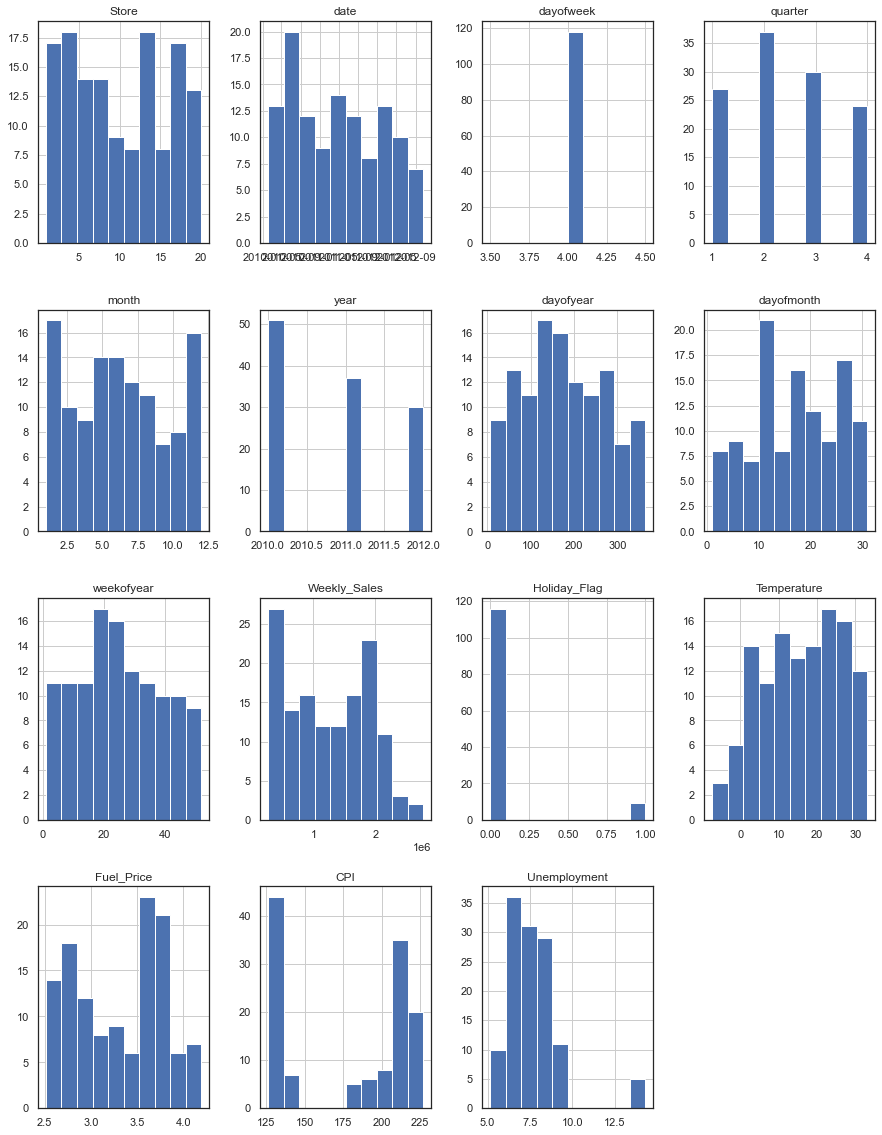

In [13]:
# Visualize variable distributions after datetime conversion

# Set size for figure
fig = plt.figure(figsize = (15,20))
# Get axes instance
ax = fig.gca()

# Plot histograms for all data variables
print("Distribution of variables after reformatting of date and temp")
data_reformat_df.hist(ax = ax)


In [14]:
# Check unique day of week: Friday
# This is coherent since they report weekly sales (described in Kaggle competition summary)
data_reformat_df.dayofweek_en.unique()

array(['Friday', nan], dtype=object)

[Text(0.5, 1.0, 'Frequency of months: order by most frequent'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Count')]

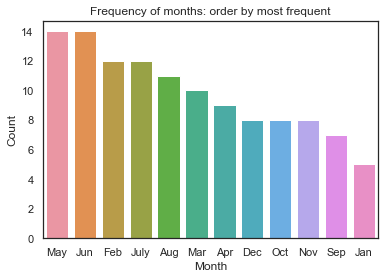

In [15]:
# Visualize most common months by name
fig = sns.countplot(x="month_en", data=data_reformat_df, order = data_reformat_df['month_en'].value_counts(ascending=False).index)
fig.set(title='Frequency of months: order by most frequent', xlabel='Month', ylabel='Count')

### Variable relationships

,Store,quarter,month,year,dayofyear,dayofmonth,weekofyear,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Store,1.000000,-0.047518,-0.022525,-0.056383,-0.029973,-0.028090,-0.031562,0.127980,-0.061869,-0.257807,0.220081,-0.551569,0.264960
quarter,-0.047518,1.000000,0.969723,-0.224266,0.965719,-0.042250,0.965885,-0.093883,-0.054429,0.291993,-0.126524,0.020610,-0.085660
month,-0.022525,0.969723,1.000000,-0.243397,0.995871,-0.034040,0.996133,-0.062015,-0.032562,0.302267,-0.142484,0.005926,-0.080812
year,-0.056383,-0.224266,-0.243397,1.000000,-0.260892,-0.114404,-0.243456,-0.017743,-0.043659,-0.139389,0.806108,0.139684,-0.147336
dayofyear,-0.029973,0.965719,0.995871,-0.260892,1.000000,0.049402,0.999702,-0.061927,-0.036901,0.309254,-0.163953,0.022160,-0.085026


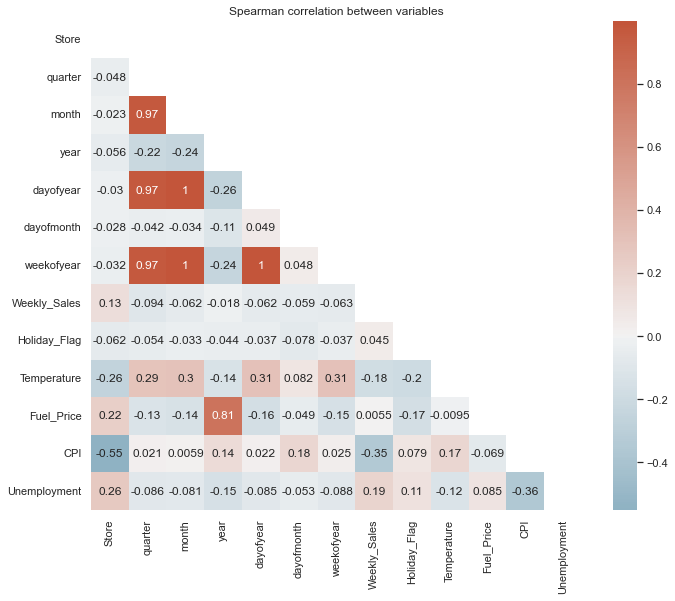

In [16]:
# #Explore possible correlation between variables

# Drop dayofweek as it is an unique value
data_corr = data_reformat_df.drop('dayofweek', axis=1)

# Correlation matrix
data_corr = data_corr.corr(method="spearman")
display(data_corr.head())

# Plot diagonal corr matrix (see seaborn documentation for example)
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(data_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
hm=sns.heatmap(data_corr, mask=mask, cmap=cmap,center=0,annot=True)

hm.set(title='Spearman correlation between variables')

plt.show()

### Target variable relationship with other variables: in depth exploration

In [17]:
# Order by Store ID and month
data_reformat_df.sort_values(by=['Store'], inplace=True)

# Create Store string ID 
data_reformat_df['Store_str'] = [str(store) for store in data_reformat_df.Store.tolist()]

# Unique number of stores
print('There are {} unique stores and {} weekly sale entries in total'.format(data_reformat_df['Store'].nunique(),data_reformat_df['Store'].value_counts().sum() ))

# Which store has the most entries: print number of values per store (visualized in value distribution plot)
print('Number of weekly sale entries per store: order from highest to lowest number of entries')
data_reformat_df['Store'].value_counts().sort_values(ascending=False).rename_axis('Store').to_frame('counts')


There are 20 unique stores and 136 weekly sale entries in total
Number of weekly sale entries per store: order from highest to lowest number of entries


,counts
Store,
3.0,12
18.0,10
1.0,9
14.0,9
13.0,9
5.0,8
7.0,8
19.0,8
2.0,8


,Store,quarter,month,year,dayofyear,dayofmonth,weekofyear,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Store,1.000000,-0.047518,-0.022525,-0.056383,-0.029973,-0.028090,-0.031562,0.127980,-0.061869,-0.257807,0.220081,-0.551569,0.264960
quarter,-0.047518,1.000000,0.969723,-0.224266,0.965719,-0.042250,0.965885,-0.093883,-0.054429,0.291993,-0.126524,0.020610,-0.085660
month,-0.022525,0.969723,1.000000,-0.243397,0.995871,-0.034040,0.996133,-0.062015,-0.032562,0.302267,-0.142484,0.005926,-0.080812
year,-0.056383,-0.224266,-0.243397,1.000000,-0.260892,-0.114404,-0.243456,-0.017743,-0.043659,-0.139389,0.806108,0.139684,-0.147336
dayofyear,-0.029973,0.965719,0.995871,-0.260892,1.000000,0.049402,0.999702,-0.061927,-0.036901,0.309254,-0.163953,0.022160,-0.085026


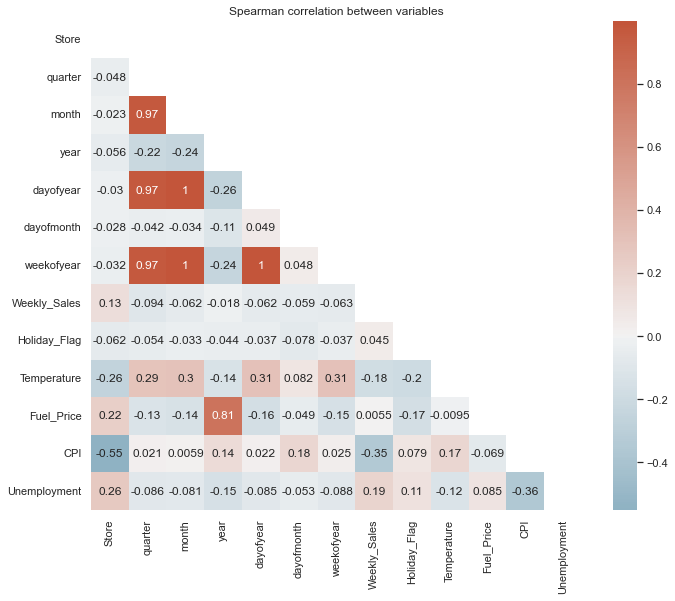

In [18]:
# #Explore possible correlation between variables

# Drop dayofweek as it is an unique value
data_corr = data_reformat_df.drop('dayofweek', axis=1)

# Correlation matrix
data_corr = data_corr.corr(method="spearman")
display(data_corr.head())

# Plot diagonal corr matrix (see seaborn documentation for example)
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(data_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
hm=sns.heatmap(data_corr, mask=mask, cmap=cmap,center=0,annot=True)

hm.set(title='Spearman correlation between variables')

plt.show()

#### Weekly Sales per month, per store and per year

[Text(0.5, 1.0, 'Weekly sales per month per year'),
 Text(0.5, 0, ''),
 Text(0, 0.5, 'Weekly Sales')]

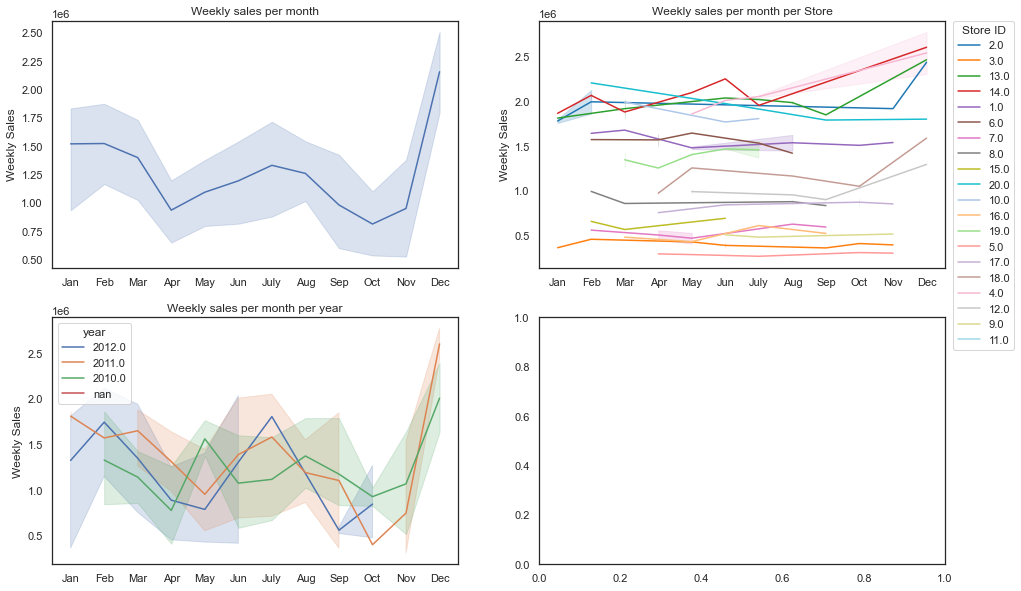

In [28]:
# Visualize scatterplot for clearer visualization of correlations

# Order dataframe by month
df_plot = data_reformat_df.copy()
df_plot = data_reformat_df.sort_values(by=['month', 'Store'])

# Convert year to string
df_plot['year'] = [str(Year) for Year in df_plot.year.tolist()]

# Set axes for grid and figure size
figure, axes = plt.subplots(2, 2, figsize=(16,10))


# Figure 1: weekly sales vs month, all stores
fig1 = sns.lineplot(data=df_plot, x="month_en", y="Weekly_Sales", sort=False, ax=axes[0,0])
fig1.set(title = 'Weekly sales per month' , xlabel='', ylabel='Weekly Sales')

# Figure 2 : weekly sales vs month per store
fig2 = sns.lineplot(data=df_plot, x="month_en", y="Weekly_Sales", hue='Store_str', palette=palette_20, ax=axes[0,1])
fig2.set(title = 'Weekly sales per month per Store' , xlabel='', ylabel='Weekly Sales')
fig2.legend(title="Store ID", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Figure 3 : weekly sales vs month per store
fig3 = sns.lineplot(data=df_plot, x="month_en", y="Weekly_Sales", hue='year', ax=axes[1,0])
fig3.set(title = 'Weekly sales per month per year' , xlabel='', ylabel='Weekly Sales')




#### Total weekly sales per store

In [31]:
# Total sales per Store. Oder dataframe by highest total sales
data_store_group= data_reformat_df.copy()
data_store_group=data_reformat_df.groupby(['Store_str'])[['Weekly_Sales']].agg('sum').sort_values(by=["Weekly_Sales"],ascending=False).rename(columns={"Weekly_Sales":"Total_Weekly_Sales"})
data_store_group.head()

,Total_Weekly_Sales
Store_str,
14.0,18835905.73
13.0,17975118.68
2.0,15544268.98
1.0,14062574.86
4.0,13042553.90


## EDA Conclusions  

- Basic data description  
    * There are 150 samples and 8 variables  
        * Categorical: *Holiday_Flag*  
        * Numerical: *Temperature, Fuel_Price, CPI, Unemployment, Weekly_Sales*   
        * Datetime: *Date*  
        * Unique: *Store*  
    * Missing values: 
        * 9% of missing values for target variables (Weekly sales; 14/150 values missing)  
        * The date and temperature variables contain highest percentage of missing values (12%)
    * Target variable:  
        * Kind of bimodal distribution, which could suggest peak sales due to certain times of the year  
        * No real extreme values found, so all values kept

<br>

- Variable distributions  
    * Year: 33% of sales data corresponds to the year 2010  
    * Year with most sales:  
    * Most frequent month: The most frequently reported months are May and June, followed by February and July
    * Months with most sales: December and July  
    * Store with most inputs: Store 3  
    * Store with highest total sales: Stores 14 and 13

<br>

- Variable relationships  

<br>

- Pre-processed variables  
    * Date: converted string to datetime and extracted date features  
    * Temperature: conversion from Fahrenheit to Celsius degrees  
    * Store string ID: extra column of string store ID

<br>

- Pre-processing to be done for machine learning modeling  
    - Pandas  
    - Sci-kit